# Exponential Degradation Model

In [ ]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
# os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

from scipy import optimize

In [ ]:
def prepare_data():
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    df_train = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    y_true = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index + 1
    
    return df_train, df_test, y_true

In [ ]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [ ]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [ ]:
sc = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = sc.fit_transform(df_train[feats])
df_test[feats] = sc.transform(df_test[feats])

In [ ]:
df_train.head()

UnitNumber  Cycle    OpSet1  ...  SensorMeasure20  SensorMeasure21  RUL
0           1      1 -0.080460  ...         0.426357         0.449323  191
1           1      2  0.218391  ...         0.333333         0.462027  190
2           1      3 -0.494253  ...         0.255814         0.242751  189
3           1      4  0.080460  ...         0.147287         0.324772  188
4           1      5 -0.218391  ...         0.178295         0.409003  187

[5 rows x 27 columns]

In [ ]:
df_test.head()

UnitNumber  Cycle  ...  SensorMeasure20  SensorMeasure21
0           1      1  ...         0.116279         0.323667
1           1      2  ...         0.364341         0.373654
2           1      3  ...         0.457364         0.442695
3           1      4  ...         0.333333         0.324220
4           1      5  ...         0.317829         0.432753

[5 rows x 26 columns]

In [ ]:
y_true.head()

RUL  UnitNumber
0  112           1
1   98           2
2   69           3
3   82           4
4   91           5

### Taking rolling averages to reduce noise

In [ ]:
window = 5

In [ ]:
df_train_mean = df_train.groupby('UnitNumber')[feats].rolling(window = window).mean()
df_train_mean = df_train_mean.reset_index()
df_train_mean.dropna(inplace = True)
df_train_mean.drop(['level_1'], axis = 1, inplace = True)
df_train_mean.head()

UnitNumber    OpSet1  ...  SensorMeasure20  SensorMeasure21
4           1 -0.098851  ...         0.268217         0.377575
5           1 -0.181609  ...         0.243411         0.348799
6           1 -0.202299  ...         0.274419         0.323281
7           1 -0.181609  ...         0.280620         0.304722
8           1 -0.179310  ...         0.333333         0.322784

[5 rows x 25 columns]

In [ ]:
df_train_mean.shape

(20231, 25)

### Selecting features using monotonicity

\begin{equation*}
Monotonicity (x) = \frac{1}{m}\sum_{j=1}^m \frac{|\text{number of positive diff} (x_j) - \text{number of negative diff} (x_j)|}{n-1}
\end{equation*}

where n is the length of data and m is the number of units. diff(x_j) is the lag difference of specific feature. 

In [ ]:
df_lag = df_train_mean.groupby('UnitNumber').diff(1)
df_lag['UnitNumber'] = df_train_mean['UnitNumber']
df_lag.dropna(inplace = True)
df_lag = df_lag.reset_index(drop = True)
df_lag.head()

OpSet1    OpSet2  OpSet3  ...  SensorMeasure20  SensorMeasure21  UnitNumber
0 -0.082759  0.100000     0.0  ...        -0.024806        -0.028777           1
1 -0.020690  0.133333     0.0  ...         0.031008        -0.025518           1
2  0.020690  0.000000     0.0  ...         0.006202        -0.018558           1
3  0.002299  0.033333     0.0  ...         0.052713         0.018061           1
4 -0.032184  0.100000     0.0  ...         0.015504         0.035902           1

[5 rows x 25 columns]

In [ ]:
def monotonicity(data):
    
    num_pos = data[data > 0].shape[0]
    num_neg = data[data < 0].shape[0]
    tot_n = data.shape[0] - 1
    
    mon_val = np.abs(num_pos - num_neg)/tot_n
    return mon_val

In [ ]:
mon_df = pd.DataFrame(columns = ['feature', 'monotonicity_val'])

for col in feats:
    mon_val = []
    for unit in df_lag.UnitNumber.unique():
        mon_val.append(monotonicity(df_lag.loc[df_lag.UnitNumber == unit, col]))
    mon_df = mon_df.append({'feature': col, 'monotonicity_val': np.mean(mon_val)}, ignore_index = True)

In [ ]:
mon_df = mon_df.sort_values(by = 'monotonicity_val', ascending = False)
mon_df.head()

feature  monotonicity_val
16  SensorMeasure14          0.157243
11   SensorMeasure9          0.147807
13  SensorMeasure11          0.116696
14  SensorMeasure12          0.105777
6    SensorMeasure4          0.092576

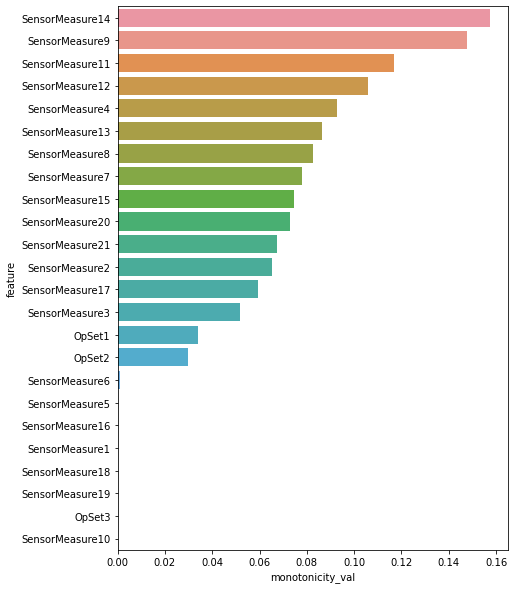

In [ ]:
fig, ax = plt.subplots(figsize = (7,10))

sns.barplot(y = mon_df.feature, x = mon_df.monotonicity_val)

Features with monotonicity value larger than 0.08 are selected.

In [ ]:
feats = mon_df.feature[mon_df.monotonicity_val > 0.08]
feats

16    SensorMeasure14
11     SensorMeasure9
13    SensorMeasure11
14    SensorMeasure12
6      SensorMeasure4
15    SensorMeasure13
10     SensorMeasure8
Name: feature, dtype: object

In [ ]:
len(feats)

7

### PCA to fuse features

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)

pca_data = pca.fit_transform(df_train_mean[feats])

pca_df = pd.DataFrame(pca_data, columns = ['pc1', 'pc2', 'pc3'])
pca_df['UnitNumber'] = df_train_mean.UnitNumber.values
pca_df['cycle'] = pca_df.groupby('UnitNumber').cumcount()+1
pca_df['RUL'] = pca_df.groupby('UnitNumber').cycle.transform('max') - pca_df.cycle
pca_df.head()

pc1       pc2       pc3  UnitNumber  cycle  RUL
0 -0.496369 -0.132625 -0.122027           1      1  187
1 -0.549425 -0.137713 -0.118303           1      2  186
2 -0.594405 -0.115734 -0.093867           1      3  185
3 -0.628940 -0.124971 -0.079502           1      4  184
4 -0.603982 -0.132597  0.020663           1      5  183

### Visualizing principal components

In [ ]:
pcs = ['pc1', 'pc2', 'pc3']

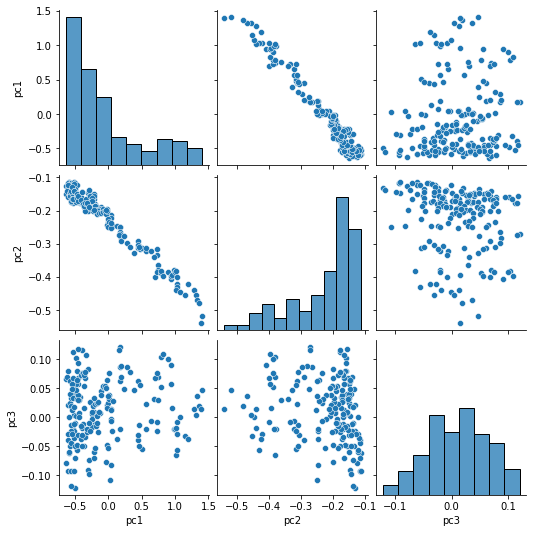

In [ ]:
sns.pairplot(data = pca_df[pca_df.UnitNumber == 1], x_vars= pcs, y_vars = pcs)

#### Choosing PC1 and PC2 and plotting

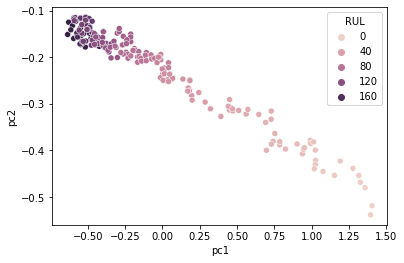

In [ ]:
sns.scatterplot(data = pca_df[pca_df.UnitNumber == 1], x = "pc1", y = "pc2", hue = "RUL")

#### Considering PC1 as a health indicator and visualizing against cycle

Text(0, 0.5, 'Health Indicator')

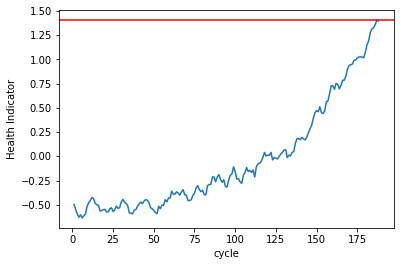

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.UnitNumber == 1], x = "cycle", y = "pc1", ax = ax)
plt.axhline(pca_df[pca_df.UnitNumber == 1].pc1.max(), color = 'r')
ax.set_ylabel("Health Indicator")

#### visualizing health indicators of all units

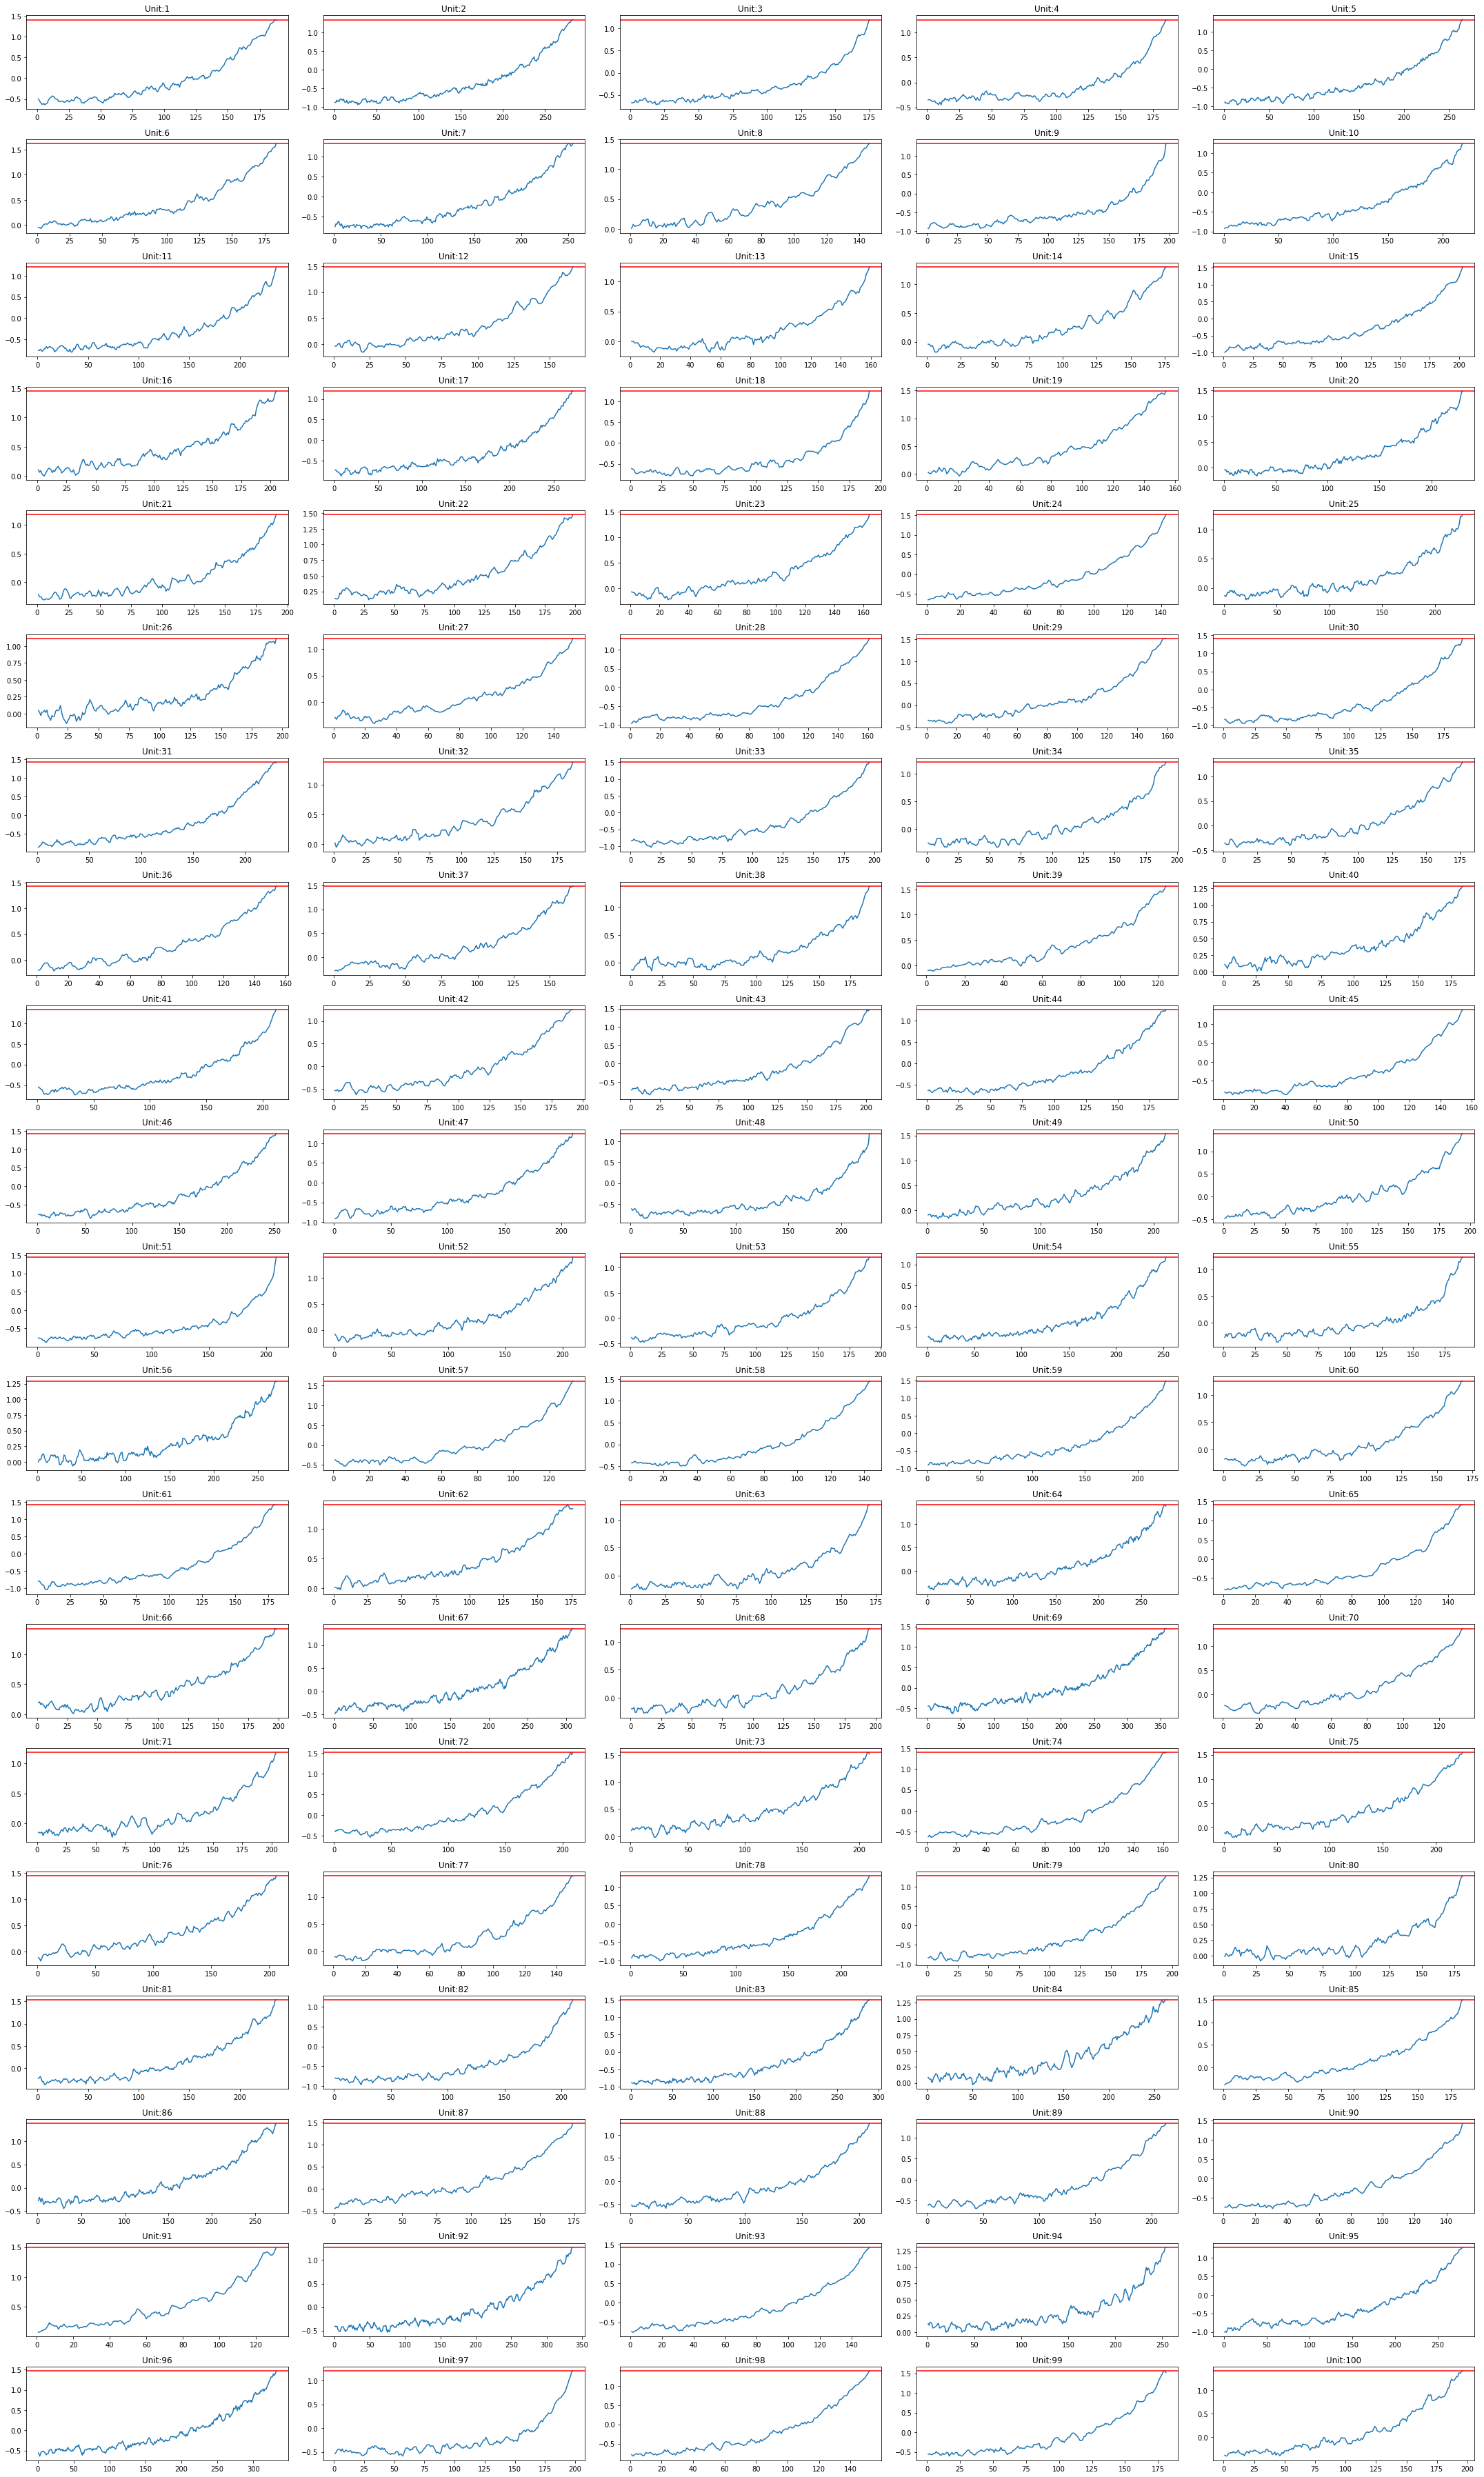

In [ ]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    sns.lineplot(data = pca_df[pca_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    ax[i].axhline(pca_df[pca_df.UnitNumber == i+1].pc1.max(), color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

### Visualizing Health Indicator values at different RULs

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

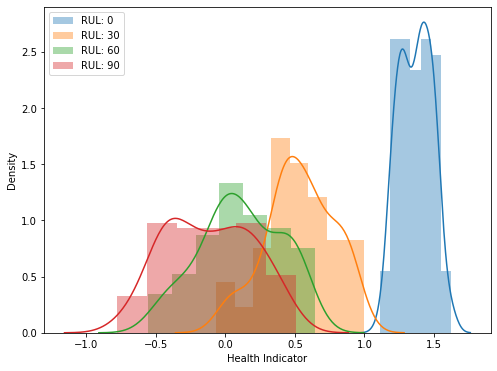

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
sns.distplot(pca_df.pc1[pca_df.RUL == 0], label= "RUL: 0")
sns.distplot(pca_df.pc1[pca_df.RUL == 30], label= "RUL: 30")
sns.distplot(pca_df.pc1[pca_df.RUL == 60], label= "RUL: 60")
sns.distplot(pca_df.pc1[pca_df.RUL == 90], label= "RUL: 90")
plt.xlabel("Health Indicator")
plt.legend()
plt.show()

As we see the spread decreases with the decrease in RUL.

### Failure Threshold

Taking a mean Health Indicator value at RUL=0 as a Failure threshold

In [ ]:
threshold = pca_df.pc1[pca_df.RUL == 0].mean()
threshold

1.366247925312483

In [ ]:
threshold_std = pca_df.pc1[pca_df.RUL == 0].std()
threshold_std

0.11653709561659333

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


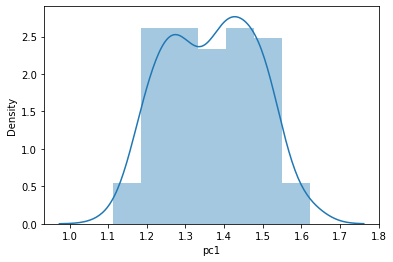

In [ ]:
sns.distplot(pca_df.pc1[pca_df.RUL == 0])

### Exponential Degradation

Exponential degradation model can be defined as below

\begin{equation*}
h(t) = \phi + \theta \ exp ( \beta t )
\end{equation*}

- where $h(t)$ is the health indicator as a function of time. 
- $\phi$ is the intercept term considered as a constant. 
- $\theta$ and $\beta$  are random parameters determining the slope of the model, where $\theta$ is lognormal-distributed and $\beta$ is Gaussian-distributed.

Fitting the exponential degradation curve for all units in train data

In [ ]:
def exp_degradation(parameters, cycle):
    '''
    Calculate an exponetial degradation of the form:
    ht = phi + theta * exp(beta * cycle)
    ''' 
    phi = parameters[0]
    theta = parameters[1]
    beta = parameters[2]
    
    ht = phi + theta * np.exp(beta * cycle)
    return ht

In [ ]:
def residuals(parameters, data, y_observed, func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters, data) - y_observed

Initial values for parameters

In [ ]:
param_0 = [-1, 0.01, 0.01]

In [ ]:
exp_params_df = pd.DataFrame(columns = ['UnitNumber', 'phi', 'theta', 'beta'])

for i in range(1,101):
    
    ht = pca_df.pc1[pca_df.UnitNumber == i]
    cycle = pca_df.cycle[pca_df.UnitNumber == i]

    OptimizeResult = optimize.least_squares(residuals, param_0, args = (cycle, ht, exp_degradation))
    phi, theta, beta = OptimizeResult.x
    
    exp_params_df = exp_params_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta}, ignore_index = True)

In [ ]:
exp_params_df.head()

UnitNumber       phi     theta      beta
0         1.0 -0.635627  0.065714  0.018378
1         2.0 -0.917313  0.046571  0.013751
2         3.0 -0.644046  0.014137  0.027443
3         4.0 -0.336294  0.004275  0.031951
4         5.0 -0.914597  0.046348  0.014524

#### Visualizing fitted exponential curve

Text(0, 0.5, 'Health Indicator')

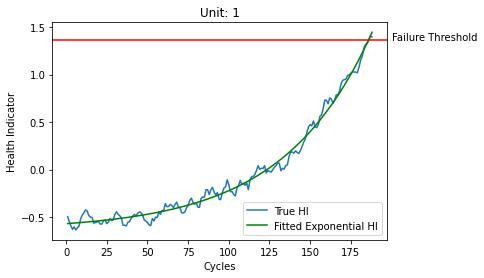

In [ ]:
phi = exp_params_df.phi[exp_params_df.UnitNumber == 1].values
theta = exp_params_df.theta[exp_params_df.UnitNumber == 1].values
beta = exp_params_df.beta[exp_params_df.UnitNumber == 1].values

cycles = pca_df.cycle[pca_df.UnitNumber == 1]
pred_ht = exp_degradation([phi, theta, beta], cycles)

fig, ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.UnitNumber == 1], x = "cycle", y = "pc1", ax = ax, label = "True HI")
sns.lineplot(y = pred_ht, x = cycles, ax = ax, color = "green", label = "Fitted Exponential HI")
ax.axhline(threshold, color = 'r')
ax.text(200,threshold - 0.01,'Failure Threshold',rotation=0)
ax.set_title("Unit: 1")
ax.set_xlabel("Cycles")
ax.set_ylabel("Health Indicator")

For all Units

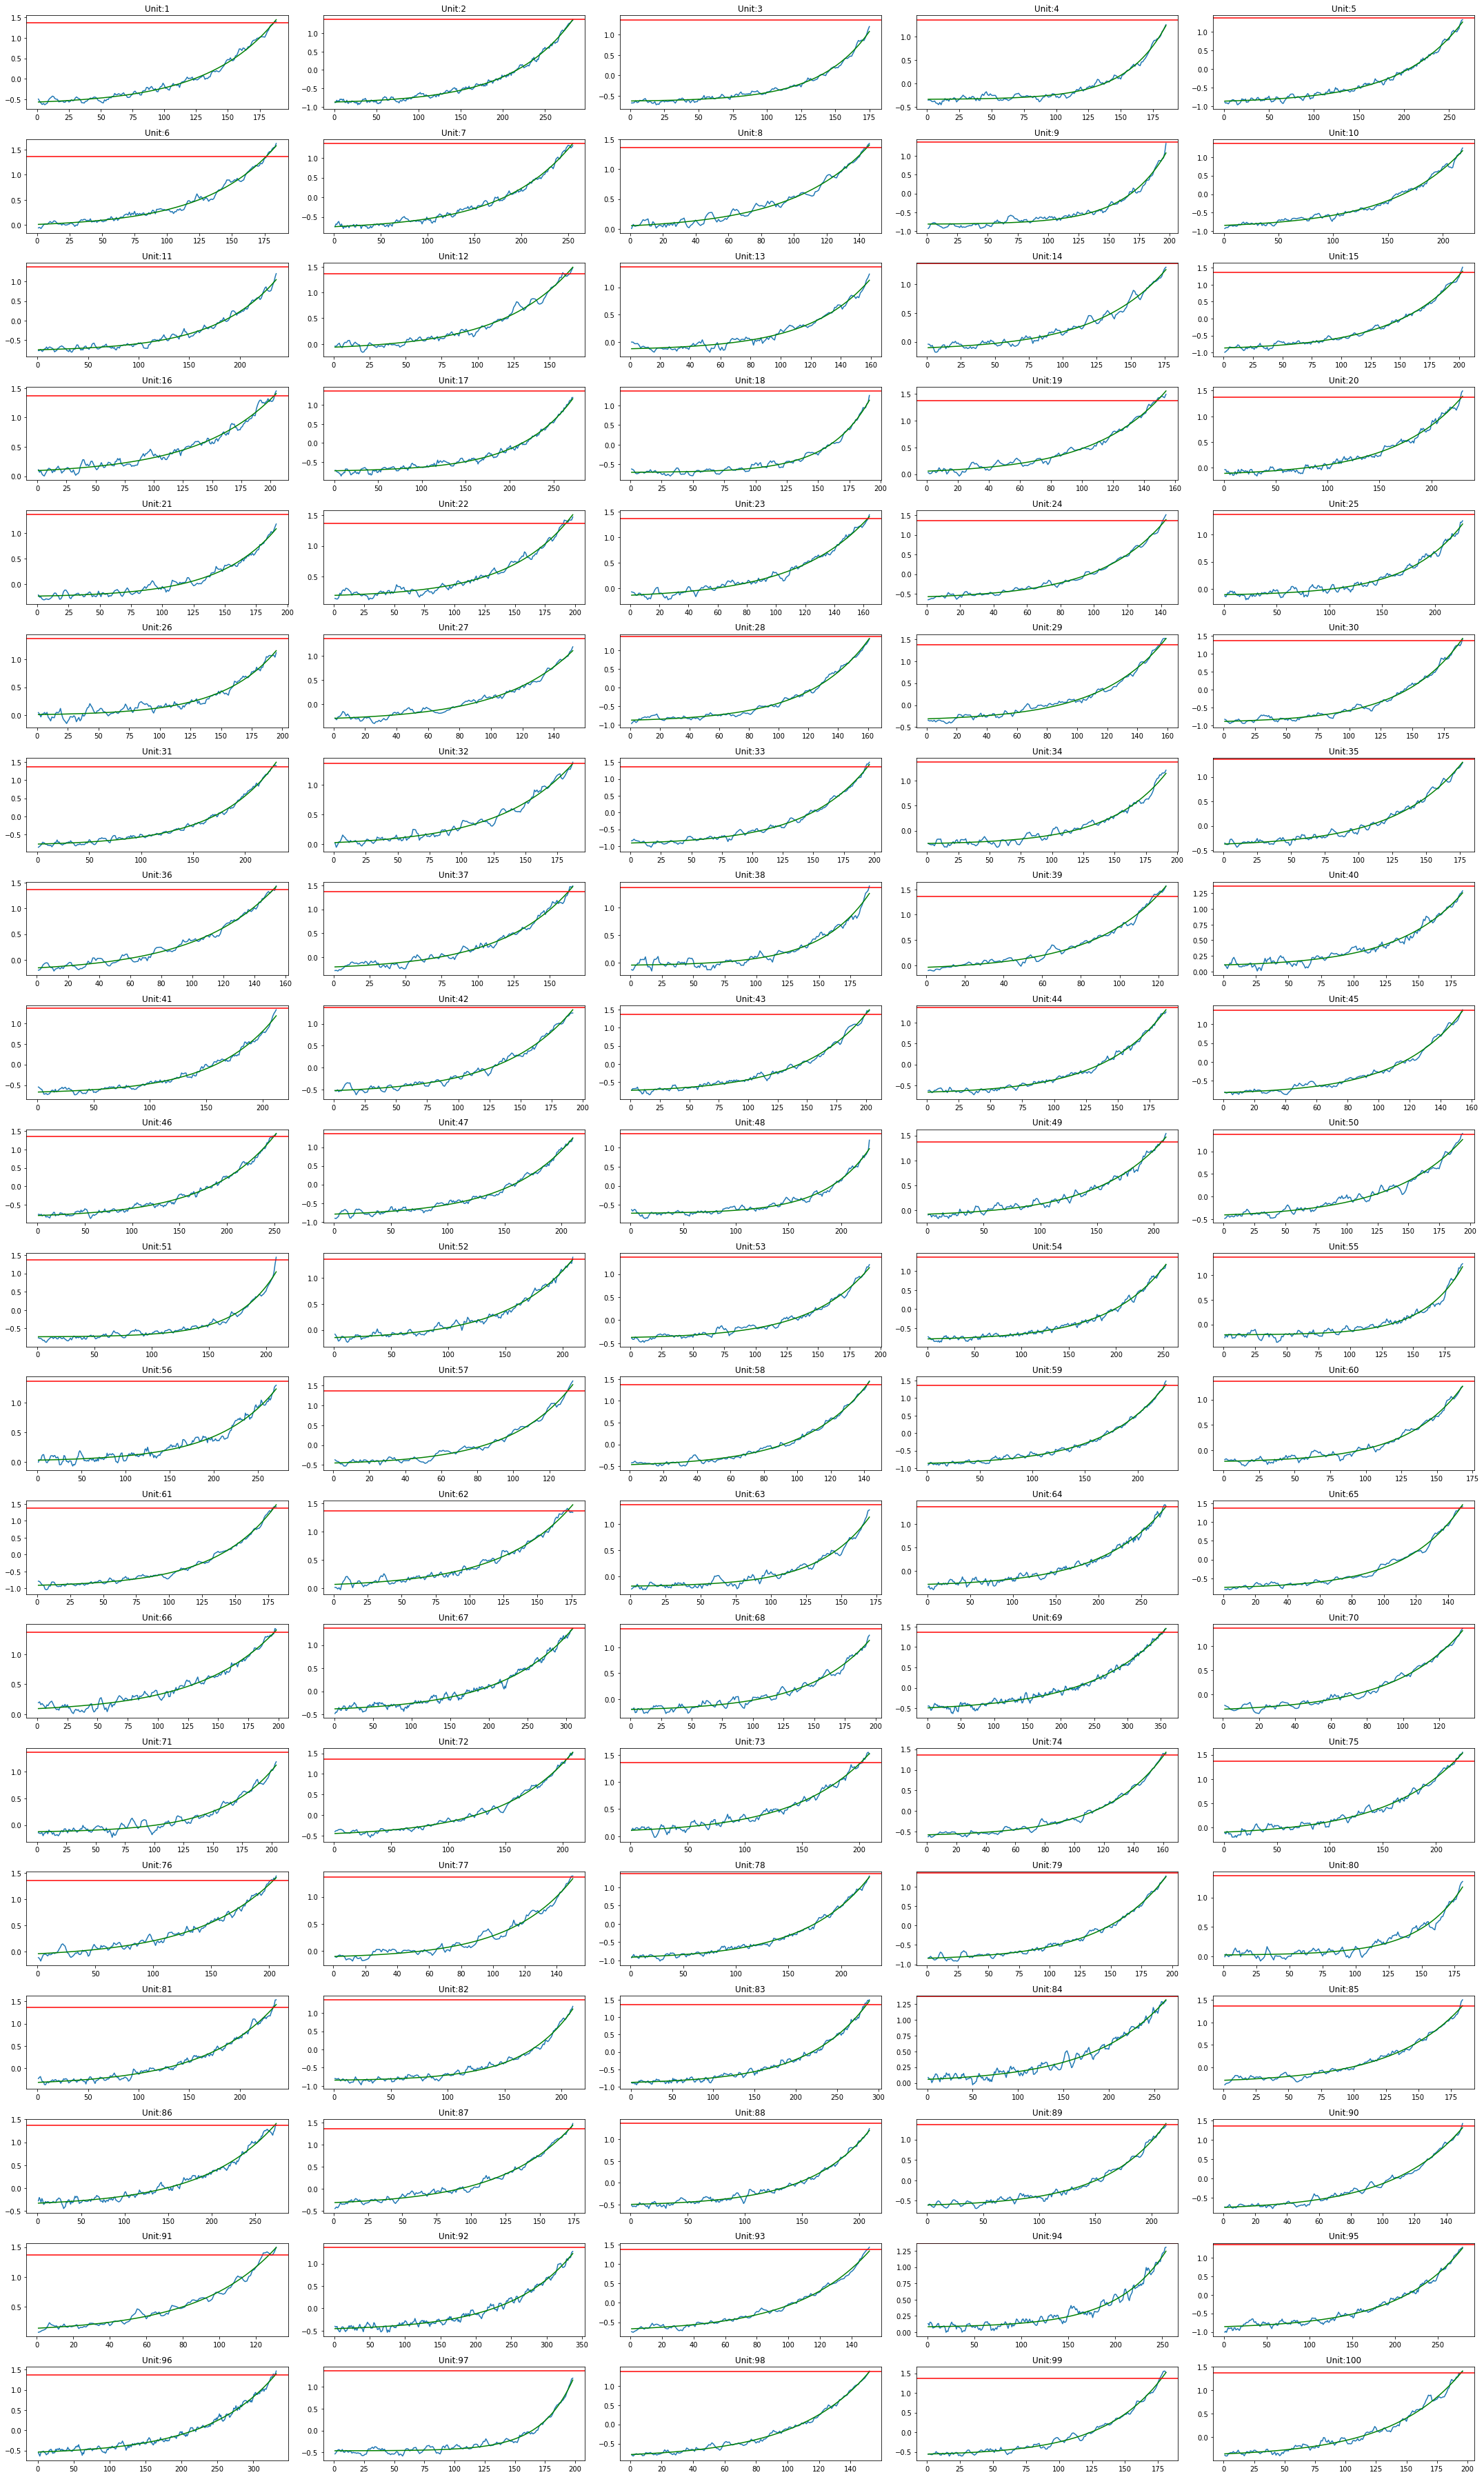

In [ ]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    
    phi = exp_params_df.phi[exp_params_df.UnitNumber == i+1].values
    theta = exp_params_df.theta[exp_params_df.UnitNumber == i+1].values
    beta = exp_params_df.beta[exp_params_df.UnitNumber == i+1].values
    
    cycles = pca_df.cycle[pca_df.UnitNumber == i+1]
    pred_ht = exp_degradation([phi, theta, beta], cycles)
    
    sns.lineplot(data = pca_df[pca_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    sns.lineplot(y = pred_ht, x = cycles, ax = ax[i], color = "green")
    ax[i].axhline(threshold, color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

The exponential curves result in good fit. Since, The last value of health indicator is different in all units, we do not see threhsold in plots.

#### Visualizing various parameters distributions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

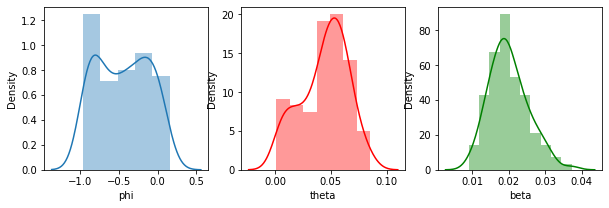

In [ ]:
fig, ax = plt.subplots(figsize = (10,3), nrows = 1, ncols = 3)
sns.distplot(exp_params_df.phi, ax = ax[0])
sns.distplot(exp_params_df.theta, ax = ax[1], color = "red")
sns.distplot(exp_params_df.beta, ax = ax[2], color = "green")

### Preparaing Test data

In [ ]:
window = 5

df_test_mean = df_test.groupby('UnitNumber')[feats].rolling(window = window).mean()
df_test_mean = df_test_mean.reset_index()
df_test_mean.dropna(inplace = True)
df_test_mean.drop(['level_1'], axis = 1, inplace = True)
df_test_mean.head()

UnitNumber  SensorMeasure14  ...  SensorMeasure13  SensorMeasure8
4           1        -0.673836  ...        -0.529412       -0.612121
5           1        -0.669894  ...        -0.500000       -0.636364
6           1        -0.679492  ...        -0.500000       -0.612121
7           1        -0.688100  ...        -0.482353       -0.612121
8           1        -0.685520  ...        -0.482353       -0.593939

[5 rows x 8 columns]

In [ ]:
pca_test_data = pca.transform(df_test_mean[feats])

pca_test_df = pd.DataFrame(pca_test_data, columns = ['pc1', 'pc2', 'pc3'])
pca_test_df['UnitNumber'] = df_test_mean.UnitNumber.values
pca_test_df['cycle'] = pca_test_df.groupby('UnitNumber').cumcount()+1
pca_test_df.head()

pc1       pc2       pc3  UnitNumber  cycle
0 -0.480441 -0.124101  0.064602           1      1
1 -0.489994 -0.122203  0.071390           1      2
2 -0.469134 -0.134640  0.025408           1      3
3 -0.507406 -0.152732  0.013009           1      4
4 -0.498859 -0.145213 -0.051034           1      5

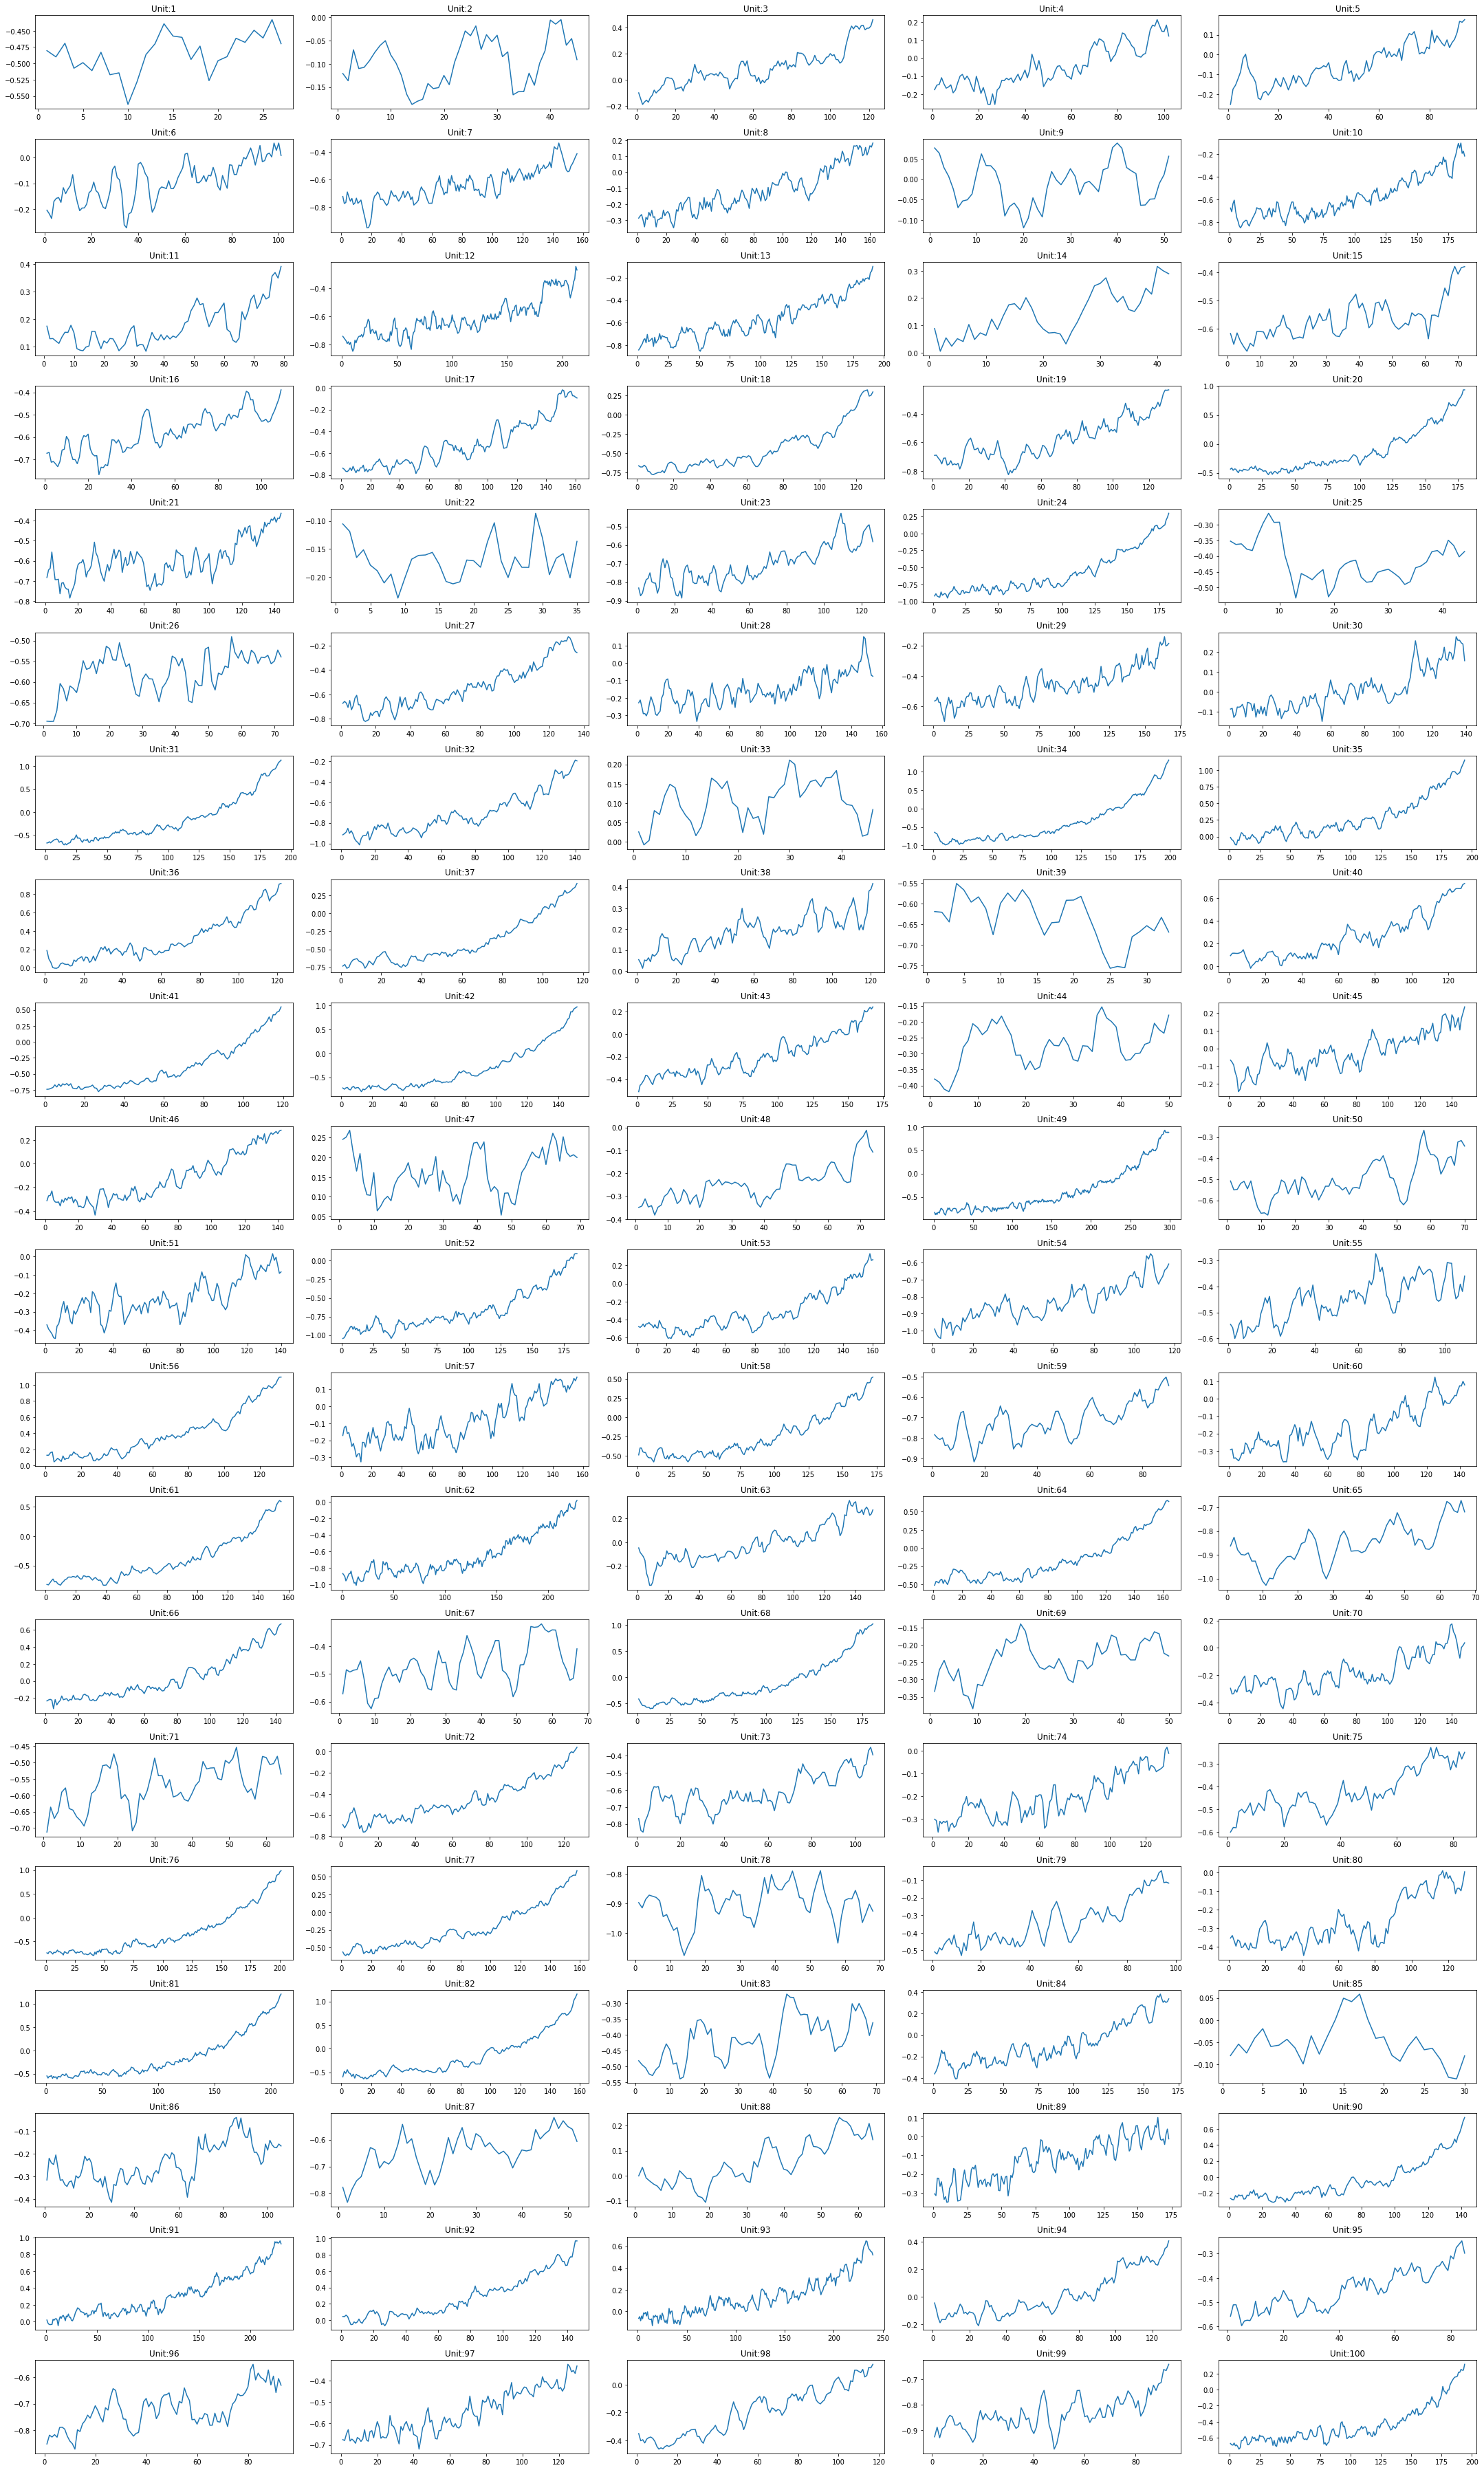

In [ ]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    
    sns.lineplot(data = pca_test_df[pca_test_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

### Predicting RUL

Steps

1. Fit an exponential model on test data using parameters as mean values and bounds as 25th and 75th percentile values of exponential models found using training data
2. Calculate total cycles to reach failure threshold
3. Find remaining useful life
4. Repeat 1-3 for all test units

In [ ]:
phi_vals = exp_params_df.phi
theta_vals = exp_params_df.theta
beta_vals = exp_params_df.beta

In [ ]:
phi_vals.mean()

-0.4511662453977499

In [ ]:
param_1 = [phi_vals.mean(), theta_vals.mean(), beta_vals.mean()]
param_1

[-0.4511662453977499, 0.0442827617788952, 0.02003310731279182]

In [ ]:
lb = 25
ub = 75
phi_bounds = [np.percentile(phi_vals, lb), np.percentile(phi_vals, ub)] 
theta_bounds = [np.percentile(theta_vals, lb), np.percentile(theta_vals, ub)] 
beta_bounds = [np.percentile(beta_vals, lb), np.percentile(beta_vals, ub)] 

In [ ]:
bounds = ([phi_bounds[0], theta_bounds[0], beta_bounds[0]], 
          [phi_bounds[1], theta_bounds[1], beta_bounds[1]])
bounds

([-0.7767914433197421, 0.030713551479334494, 0.01632868279200794],
 [-0.14914476120685713, 0.059750435214471424, 0.02301529216191459])

In [ ]:
result_test_df = pd.DataFrame(columns = ['UnitNumber', 'phi', 'theta', 'beta', 'Pred_RUL', 'True_RUL'])

for i in pca_test_df.UnitNumber.unique():
    
    ht = pca_test_df.pc1[pca_test_df.UnitNumber == i]
    cycle = pca_test_df.cycle[pca_test_df.UnitNumber == i]
    
    OptimizeResult = optimize.least_squares(residuals, param_1, bounds=bounds,
                                            args = (cycle, ht, exp_degradation))
    phi, theta, beta = OptimizeResult.x
    total_cycles = np.log((threshold - phi) / theta) / beta
    RUL = total_cycles - cycle.max()
    
    result_test_df = result_test_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta,
                                         'Pred_RUL': RUL, 'True_RUL': y_true.RUL[y_true.UnitNumber == i].values[0]}, 
                                         ignore_index = True)

In [ ]:
result_test_df.head()

UnitNumber       phi     theta      beta    Pred_RUL  True_RUL
0         1.0 -0.560818  0.053971  0.023015  128.345283     112.0
1         2.0 -0.152439  0.032075  0.023015  122.606940      98.0
2         3.0 -0.149145  0.059750  0.018523   52.553348      69.0
3         4.0 -0.232891  0.059750  0.019077   70.306308      82.0
4         5.0 -0.220934  0.059750  0.019306   75.867237      91.0

### Results

Text(0, 0.5, 'True RUL')

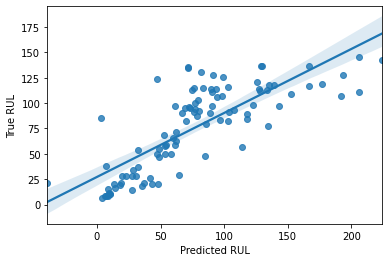

In [ ]:
sns.regplot(x = result_test_df.Pred_RUL, y = result_test_df.True_RUL)
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

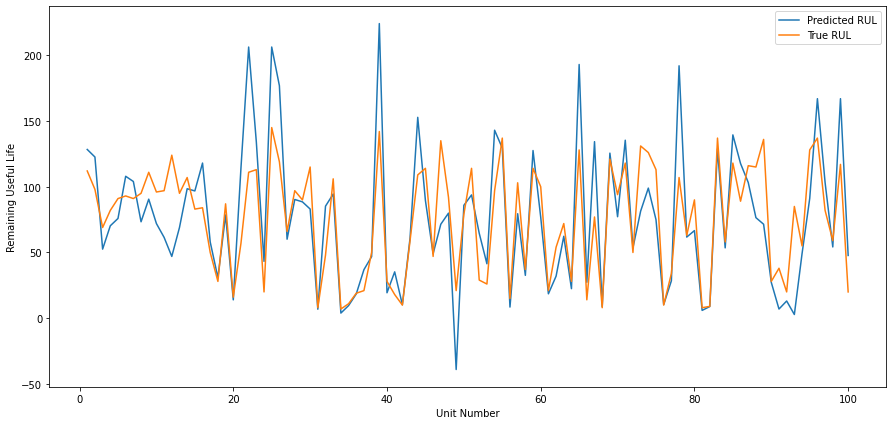

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = result_test_df.UnitNumber, y = result_test_df.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = result_test_df.UnitNumber, y = result_test_df.True_RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

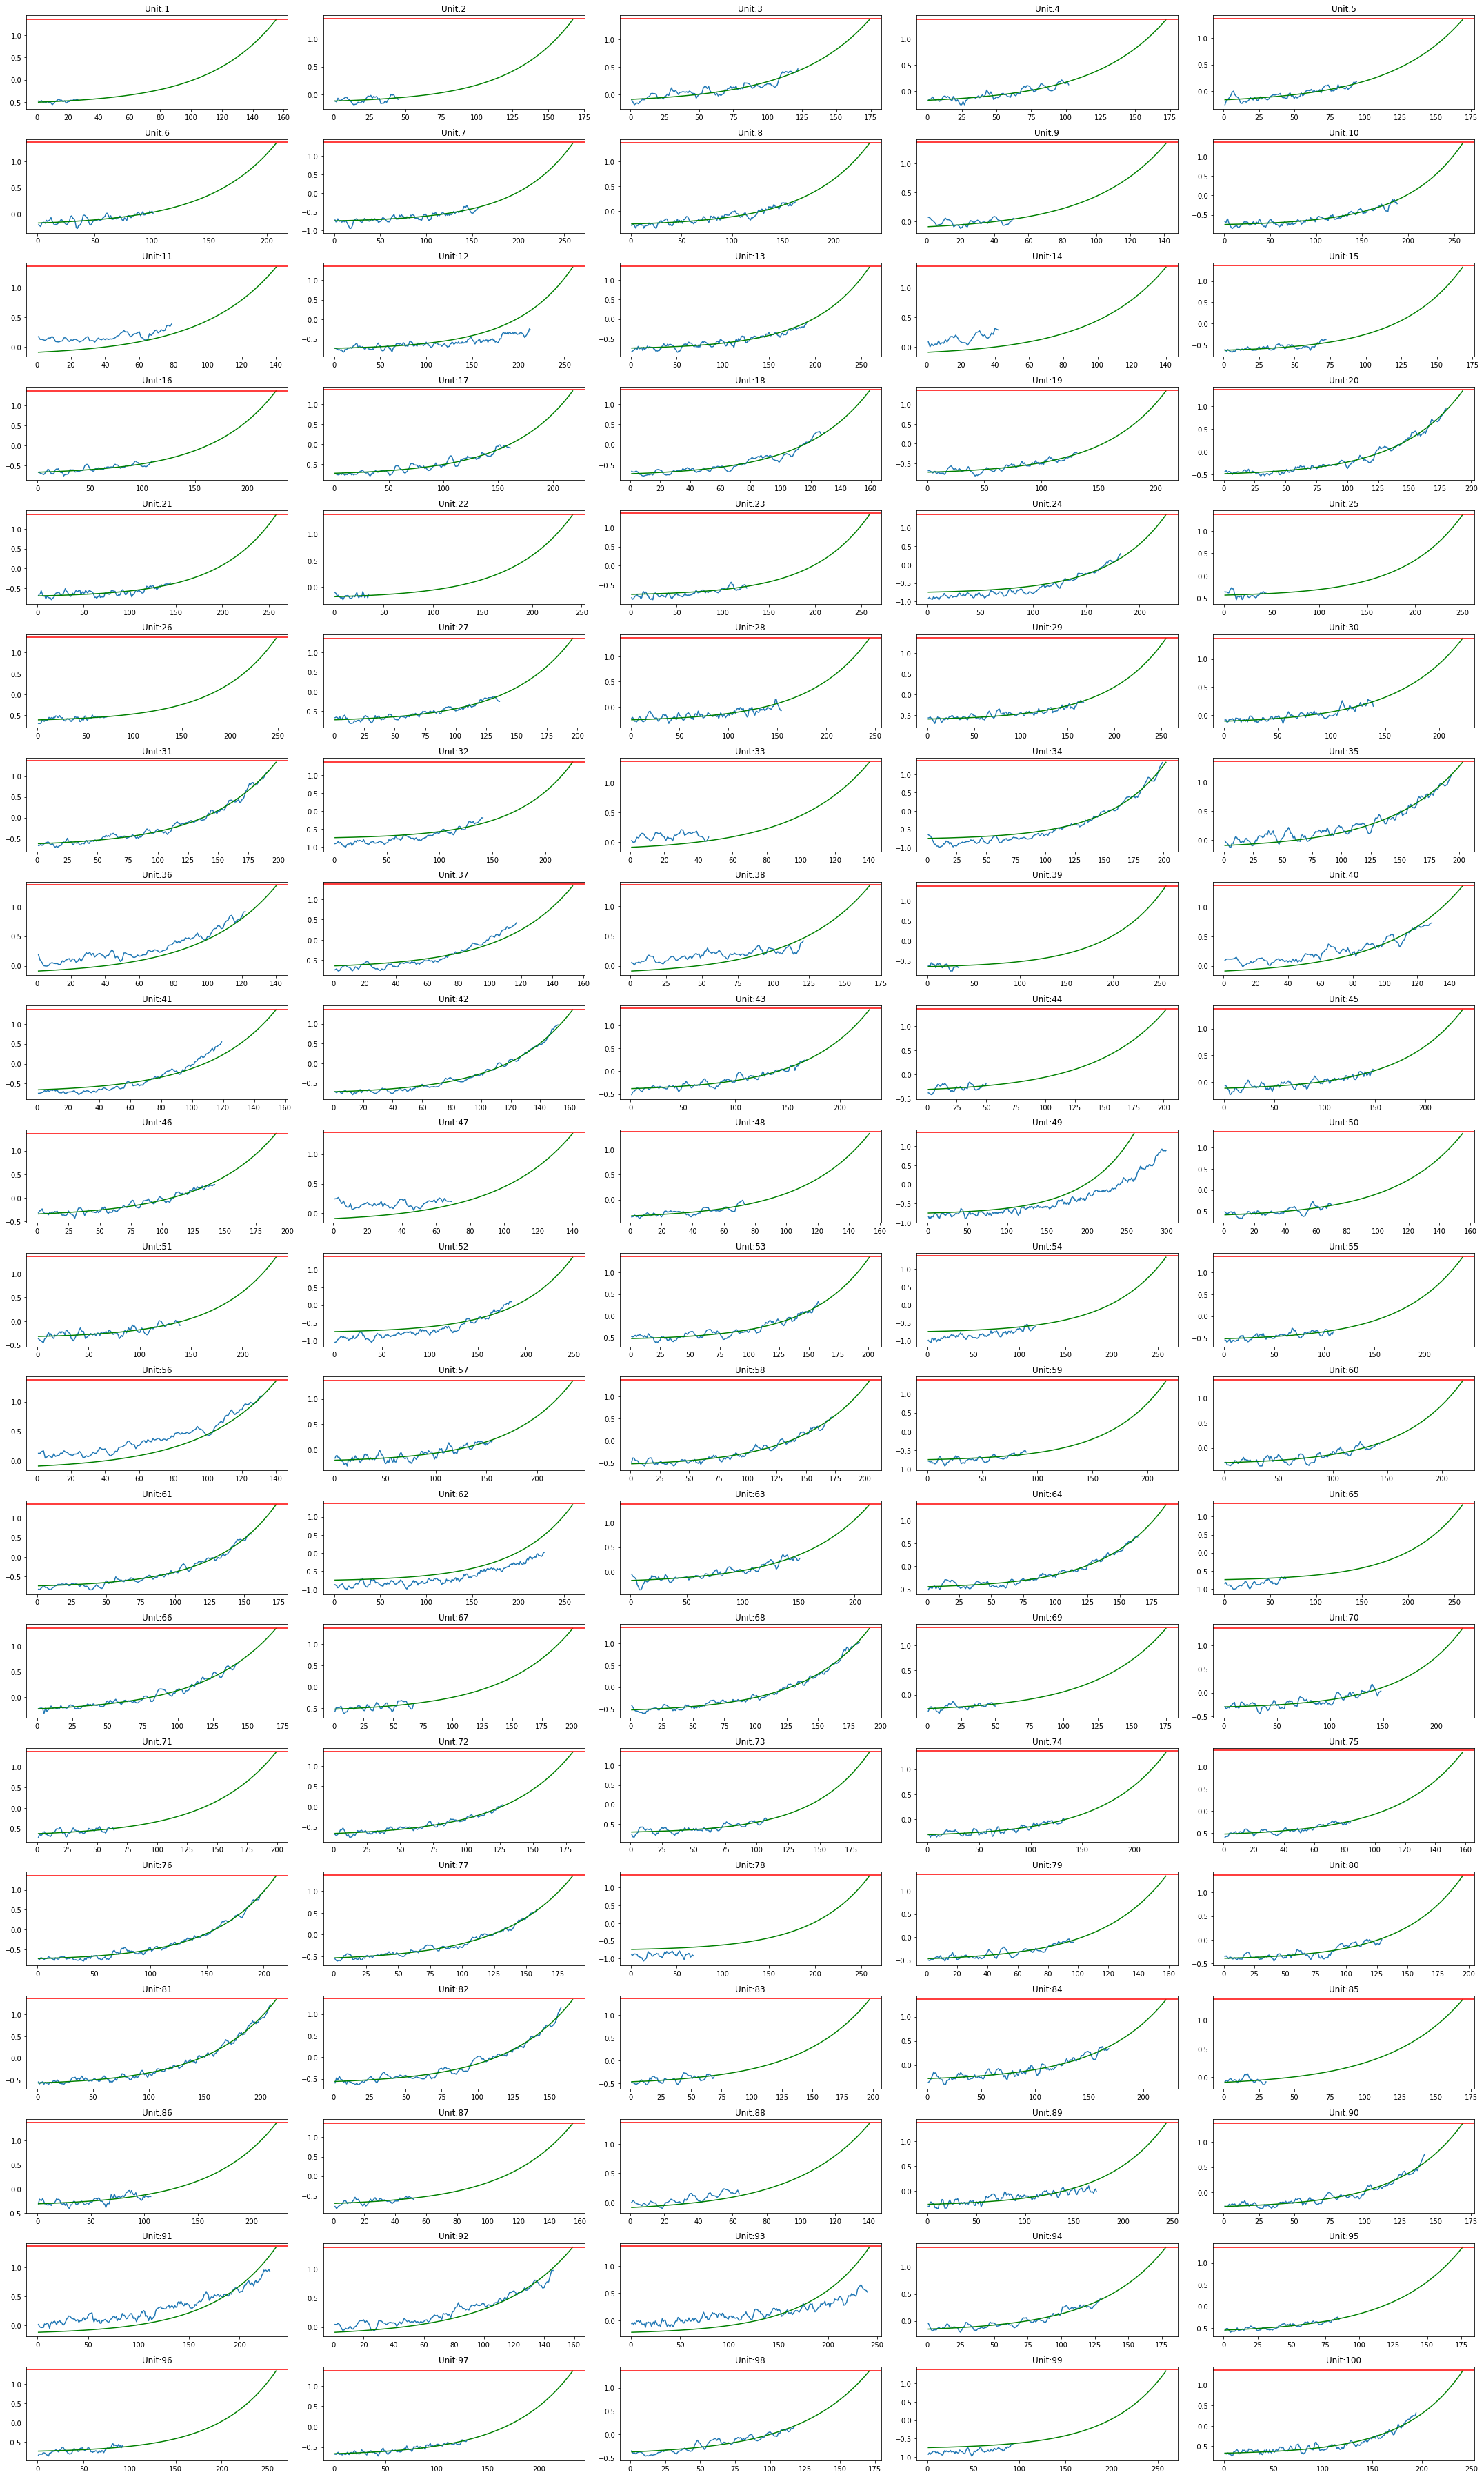

In [ ]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    
    phi = result_test_df.phi[result_test_df.UnitNumber == i+1].values[0]
    theta = result_test_df.theta[result_test_df.UnitNumber == i+1].values[0]
    beta = result_test_df.beta[result_test_df.UnitNumber == i+1].values[0]
    Pred_RUL = result_test_df.Pred_RUL[result_test_df.UnitNumber == i+1].values[0]
    
    cycles = pca_test_df.cycle[pca_test_df.UnitNumber == i+1]
    total_cycles = [j for j in range(1, int(cycles.max() + Pred_RUL + 1))]
    pred_ht = exp_degradation([phi, theta, beta], pd.Series(total_cycles))
    
    sns.lineplot(data = pca_test_df[pca_test_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    sns.lineplot(y = pred_ht, x = total_cycles, ax = ax[i], color = "green")
    ax[i].axhline(threshold, color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

### Errors

In [ ]:
mean_squared_error(result_test_df.True_RUL, result_test_df.Pred_RUL)

1013.68899069928

In [ ]:
mean_absolute_error(result_test_df.True_RUL, result_test_df.Pred_RUL)

22.762495021951462

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(result_test_df.True_RUL, result_test_df.Pred_RUL)

33.655654355634574